In [333]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import collections
from pathlib import Path
import os

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, recall_score, precision_score
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import Normalizer

import pickle

# Для коробочных решений
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Проделываем все операции из прошлой ЛР

In [334]:
df = pd.read_csv("train.csv", index_col="PassengerId")
df = df.drop(["Name", "Ticket"], axis = 1)
df["Age"] = df["Age"].fillna(df["Age"].mean())
df = df.drop(["Cabin"], axis = 1)
df["Embarked"] = df["Embarked"].fillna("S")
LE = LabelEncoder()
df['Sex'] = LE.fit_transform(df['Sex'])
df['Embarked'] = LE.fit_transform(df['Embarked'])

In [335]:
my_random_seed = 322

x = df.drop(columns='Survived')
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x.to_numpy(), 
    y.to_numpy(), test_size = 0.2, random_state = my_random_seed)

In [336]:
def get_scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    fig = plt.figure(figsize = (18, 5))
    matrix = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 1, 1)
    ConfusionMatrixDisplay(matrix).plot(ax = ax)
    plt.show()
    ax = plt.subplot(1, 1, 1)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-curve", ax = ax)
    plt.show()

In [337]:
def create_file(filename):
    filename = 'models/' + filename
    if not os.path.exists(filename):
        open(filename, 'w').close()

In [338]:
create_file('my_log_reg.pkl')
create_file('sklearn_log_reg.pkl')

create_file('my_svm.pkl')
create_file('sklearn_svm.pkl')

create_file('my_knn.pkl')
create_file('sklearn_knn.pkl')

create_file('my_naive_bayes.pkl')
create_file('sklearn_naive_bayes.pkl')

Логистическая регрессия

In [339]:
class Logistic(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, nepoch, batch_size):
        self.lr = lr
        self.nepoch = nepoch
        self.batch_size = batch_size
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0], 1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp
        
    def predict(self, main_data):
        main_data = np.concatenate((main_data, np.ones((main_data.shape[0],1))), axis = 1)
        p = np.dot(self.W, main_data.T)
        s = self.sigmoid(p)
        return (s > 0.5).astype('int64')

    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(-x))
        return self.l

In [340]:
log_reg = Pipeline(steps = [('normalizer', Normalizer()), ('log', Logistic(0.1, 10, 5))])
print(log_reg.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('log', Logistic(batch_size=5, lr=0.1, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'log': Logistic(batch_size=5, lr=0.1, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'log__batch_size': 5, 'log__lr': 0.1, 'log__nepoch': 10}


{'log__batch_size': 1, 'log__lr': 0.01, 'log__nepoch': 20}
Accuracy train: 0.6825962769624742
Accuracy: 0.7150837988826816
Recall: 0.4383561643835616
Precision: 0.7619047619047619


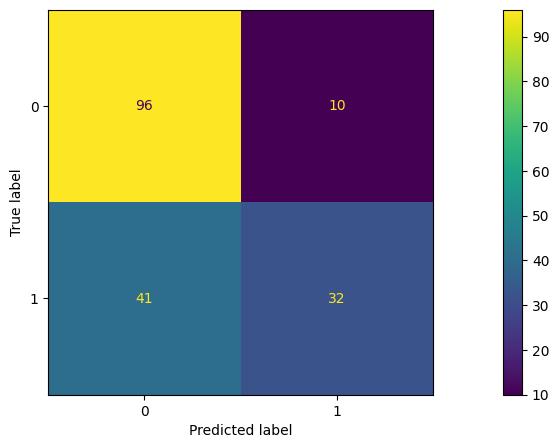

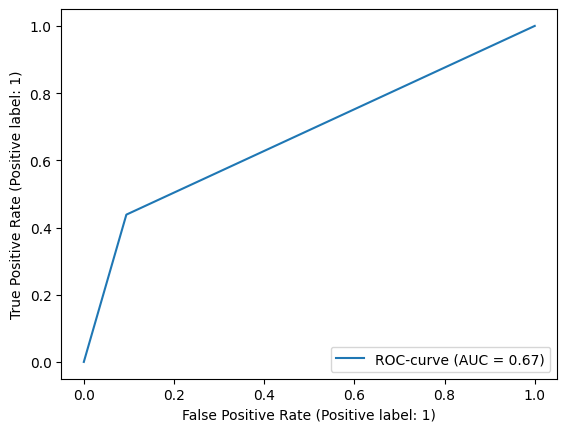

In [341]:
gscv = GridSearchCV(estimator = log_reg, param_grid={'log__nepoch': [1, 5, 10, 20], 'log__batch_size': [1, 5, 10], 'log__lr': [0.1, 0.01, 0.001]})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")

get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/my_log_reg.pkl', 'wb'))

"Коробочная" Логистическая регрессия

In [342]:
log_reg = Pipeline(steps = [('normalizer', Normalizer()),('log', SGDClassifier(loss = 'log_loss'))])
print(log_reg.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('log', SGDClassifier(loss='log_loss'))], 'verbose': False, 'normalizer': Normalizer(), 'log': SGDClassifier(loss='log_loss'), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'log__alpha': 0.0001, 'log__average': False, 'log__class_weight': None, 'log__early_stopping': False, 'log__epsilon': 0.1, 'log__eta0': 0.0, 'log__fit_intercept': True, 'log__l1_ratio': 0.15, 'log__learning_rate': 'optimal', 'log__loss': 'log_loss', 'log__max_iter': 1000, 'log__n_iter_no_change': 5, 'log__n_jobs': None, 'log__penalty': 'l2', 'log__power_t': 0.5, 'log__random_state': None, 'log__shuffle': True, 'log__tol': 0.001, 'log__validation_fraction': 0.1, 'log__verbose': 0, 'log__warm_start': False}


{'log__alpha': 0.0001, 'log__max_iter': 1000}
Accuracy train: 0.6980202895695854
Accuracy: 0.7597765363128491
Recall: 0.4657534246575342
Precision: 0.8947368421052632


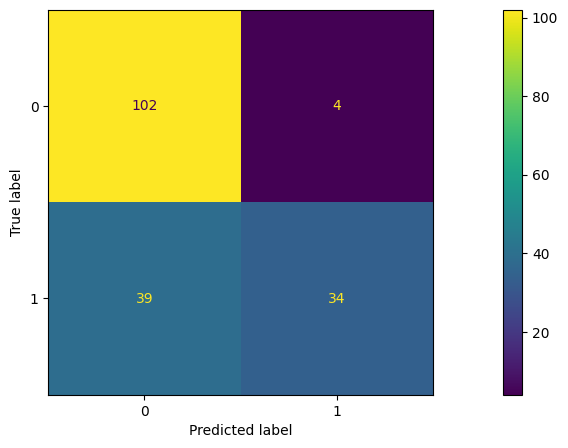

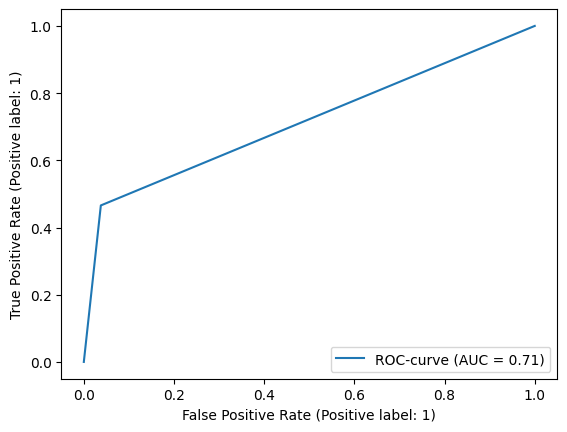

In [343]:
gscv = GridSearchCV(estimator = log_reg, param_grid={'log__max_iter': [100, 1000, 1500], 'log__alpha': [0.1, 0.001, 0.0001]})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")
 
get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/sklearn_log_reg.pkl', 'wb'))

SVM

In [344]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, lambd,  batch_size, nepoch):
        self.nepoch = nepoch
        self.lr = lr
        self.lambd = lambd
        self.batch_size = batch_size
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                
                p = np.dot(self.W, xb.T)

                sums = np.zeros_like(self.W)
                for i in range(len(p)):
                    if 1 - p[i] * yb[i] > 0:
                        sums -= xb[i] * yb[i]

                dp = 2 * self.lambd * self.W + sums
                self.W -= self.lr * dp
                
                
    def predict(self, main_data):
        main_data = np.concatenate((main_data, np.ones((main_data.shape[0],1))), axis=1)
        p = np.dot(self.W, main_data.T)
        return np.sign(p)

In [345]:
y_test_copy = np.copy(y_test)
y_train_copy = np.copy(y_train)

y_test[y_test == 0] = -1
y_train[y_train == 0] = -1

In [346]:
svm = Pipeline(steps = [('normalizer', Normalizer()), ('lin', SVM(0.03, 0.00001, 10, 10))])
print(svm.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'lin': SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__batch_size': 10, 'lin__lambd': 1e-05, 'lin__lr': 0.03, 'lin__nepoch': 10}


{'lin__batch_size': 1, 'lin__lambd': 0.001, 'lin__lr': 0.01, 'lin__nepoch': 10}
Accuracy train: 0.6882103811681276
Accuracy: 0.7150837988826816
Recall: 0.4657534246575342
Precision: 0.7391304347826086


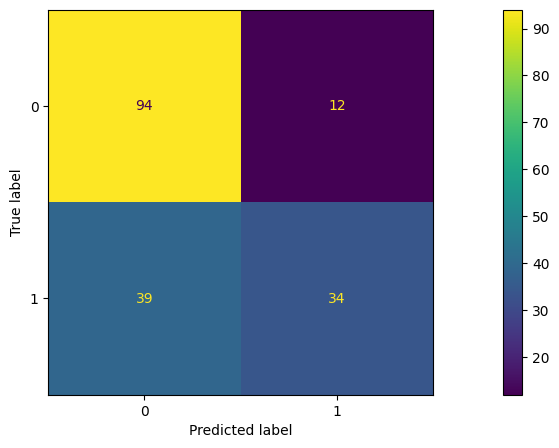

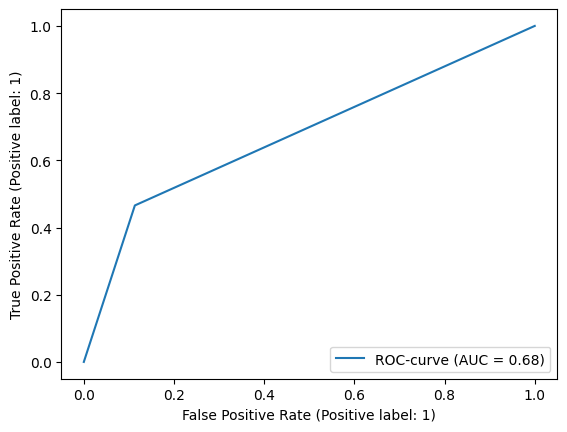

In [347]:
gscv = GridSearchCV(estimator = svm, param_grid={'lin__lambd': [0, 0.00001, 0.001, 0.1], 'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.5, 0.1, 0.01, 0.001]})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")
 
get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/my_svm.pkl', 'wb'))

"Коробочный" SVM

In [348]:
svm = Pipeline(steps = [('normalizer', Normalizer()),('lin', SGDClassifier(loss = 'hinge'))])
print(svm.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SGDClassifier())], 'verbose': False, 'normalizer': Normalizer(), 'lin': SGDClassifier(), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__alpha': 0.0001, 'lin__average': False, 'lin__class_weight': None, 'lin__early_stopping': False, 'lin__epsilon': 0.1, 'lin__eta0': 0.0, 'lin__fit_intercept': True, 'lin__l1_ratio': 0.15, 'lin__learning_rate': 'optimal', 'lin__loss': 'hinge', 'lin__max_iter': 1000, 'lin__n_iter_no_change': 5, 'lin__n_jobs': None, 'lin__penalty': 'l2', 'lin__power_t': 0.5, 'lin__random_state': None, 'lin__shuffle': True, 'lin__tol': 0.001, 'lin__validation_fraction': 0.1, 'lin__verbose': 0, 'lin__warm_start': False}


{'lin__alpha': 0.0001, 'lin__max_iter': 100}
Accuracy train: 0.7022456416822613
Accuracy: 0.7262569832402235
Recall: 0.3424657534246575
Precision: 0.9615384615384616


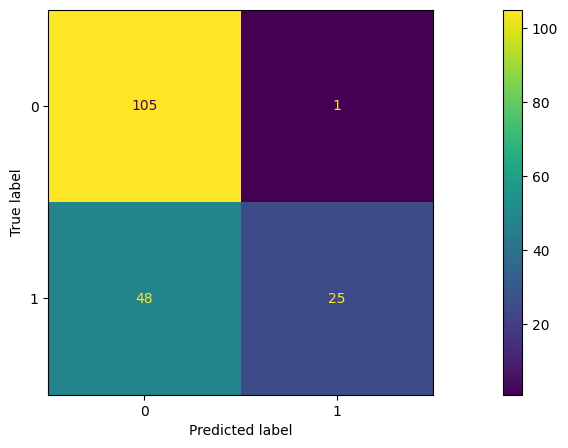

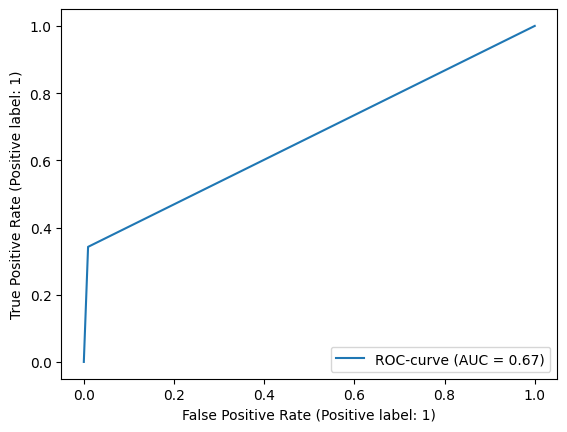

In [349]:
gscv = GridSearchCV(estimator = svm, param_grid={'lin__max_iter': [100, 1000, 1500], 'lin__alpha': [0.1, 0.001, 0.0001]})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")

get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/sklearn_svm.pkl', 'wb'))

KNN

In [350]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def euclidean_distance(self, data, row):
        distance = 0
        for i in range(len(data)): 
            distance += (data[i] - row[i]) ** 2
        return math.sqrt(distance)
        
    def predict(self, dataX):
        res = np.ndarray((dataX.shape[0],))
        for j, data in enumerate(dataX):
            distances = []
            for i, row in enumerate(self.data):
                distances.append((self.euclidean_distance(data, row), self.labels[i]))
            distances.sort(key = lambda tup: tup[0])
            dictionary = collections.defaultdict(int)
            for i in range(self.k):
                dictionary[distances[i][1]] += 1
            res[j] = max(dictionary.items(), key = lambda tup: tup[1])[0]
        return res

In [351]:
y_test = np.copy(y_test_copy)
y_train = np.copy(y_train_copy)

In [352]:
knn = Pipeline(steps = [('knn', KNN(5))])
print(knn.get_params())

{'memory': None, 'steps': [('knn', KNN(k=5))], 'verbose': False, 'knn': KNN(k=5), 'knn__k': 5}


{'knn__k': 8}
Accuracy train: 0.7275189599133262
Accuracy: 0.776536312849162
Recall: 0.6575342465753424
Precision: 0.7619047619047619


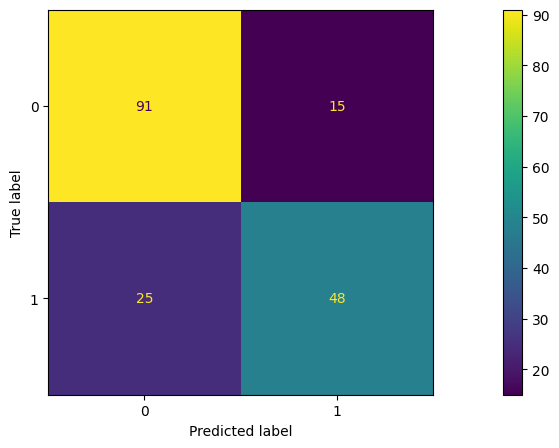

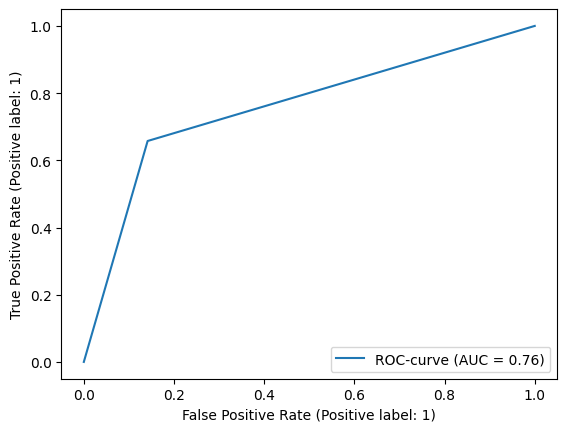

In [353]:
test_k = list(range(1, 24))

gscv = GridSearchCV(estimator = knn, param_grid={'knn__k': test_k})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")

get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/my_knn.pkl', 'wb'))

"Коробочный" KNN

In [354]:
knn = Pipeline(steps = [('knn', KNeighborsClassifier(4))])
print(knn.get_params())

{'memory': None, 'steps': [('knn', KNeighborsClassifier(n_neighbors=4))], 'verbose': False, 'knn': KNeighborsClassifier(n_neighbors=4), 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'uniform'}


{'knn__n_neighbors': 7}
Accuracy train: 0.716320299418891
Accuracy: 0.7541899441340782
Recall: 0.6438356164383562
Precision: 0.7230769230769231


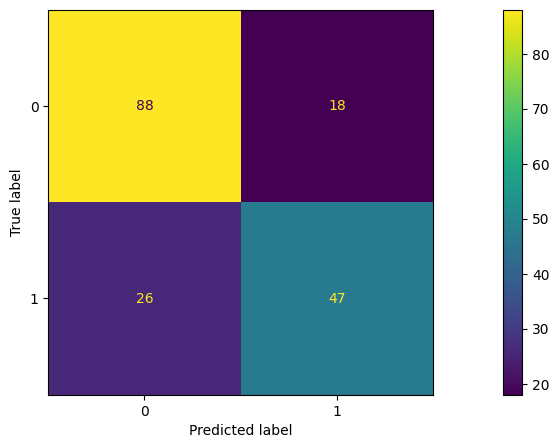

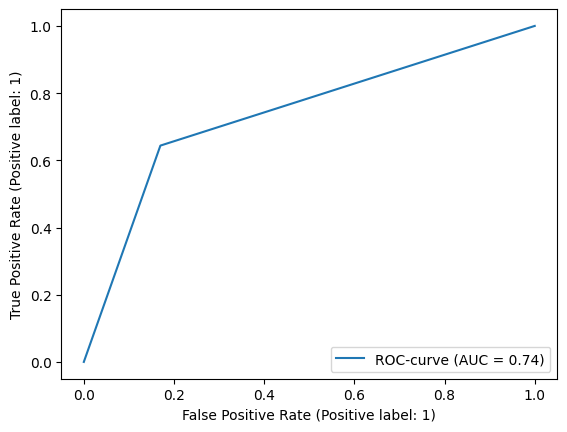

In [355]:
gscv = GridSearchCV(estimator = knn, param_grid={'knn__n_neighbors': test_k})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")

get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/sklearn_knn.pkl', 'wb'))

Naive Bayes

In [356]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, bins):
        self.bins = bins
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = []
        for j in np.unique(labels):
            self.classes.append([])
            for i in range (data.shape[1]):
                self.classes[j].append([*np.histogram(data[labels == j, i], bins = self.bins)])
                self.classes[j][-1][0] = self.classes[j][-1][0].astype('float64') / len(data[labels == j, i])
        self.prclasses = np.unique(labels, return_counts = True)[1] / len(labels)
        
    def predict(self, main_data):
        res = np.ndarray((main_data.shape[0],))
        for j, data in enumerate(main_data):
            maximum = 0
            ans = 0
            for i in range(len(self.classes)):
                p = self.prclasses[i]
                for k in range(len(self.classes[i])):
                    ind = np.digitize(data[k], self.classes[i][k][1])
                    
                    if ind >= len(self.classes[i][k][1]) or ind <= 0:
                        p = 0
                    else:
                        p *= self.classes[i][k][0][ind - 1]
                if p > maximum:
                    maximum = p
                    ans = i
            res[j] = ans
        return res 

In [357]:
naive_bayes = Pipeline(steps = [('normalizer', Normalizer()), ('bn', NaiveBayes(10))])
naive_bayes.get_params()

{'memory': None,
 'steps': [('normalizer', Normalizer()), ('bn', NaiveBayes(bins=10))],
 'verbose': False,
 'normalizer': Normalizer(),
 'bn': NaiveBayes(bins=10),
 'normalizer__copy': True,
 'normalizer__norm': 'l2',
 'bn__bins': 10}

{'bn__bins': 68}
Accuracy train: 0.743011917659805
Accuracy: 0.7318435754189944
Recall: 0.5616438356164384
Precision: 0.7192982456140351


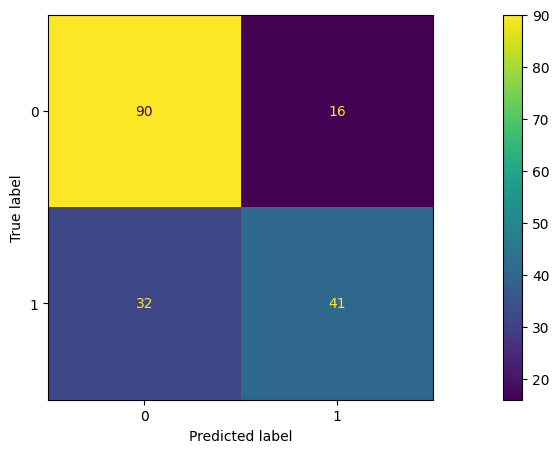

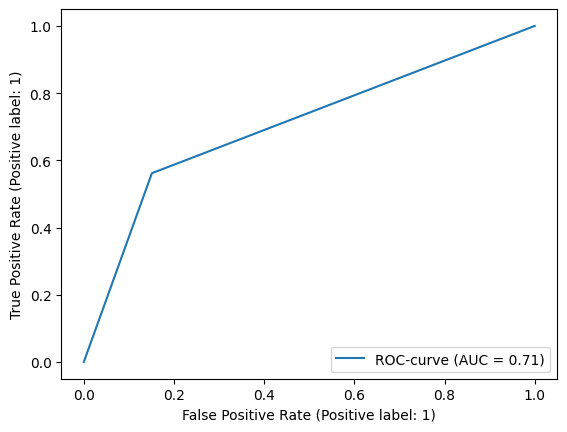

In [358]:
test_bins = list(range(2, 99))

gscv = GridSearchCV(estimator = naive_bayes, param_grid={'bn__bins': test_bins})
gscv.fit(x_train, y_train)
print(gscv.best_params_)
print(f"Accuracy train: {gscv.best_score_}")

get_scores(gscv.best_estimator_, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/my_naive_bayes.pkl', 'wb'))

"Коробочное" решение Naive Bayes

Accuracy: 0.776536312849162
Recall: 0.6164383561643836
Precision: 0.7894736842105263


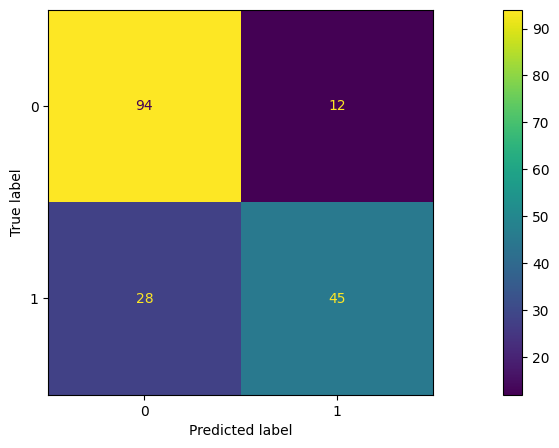

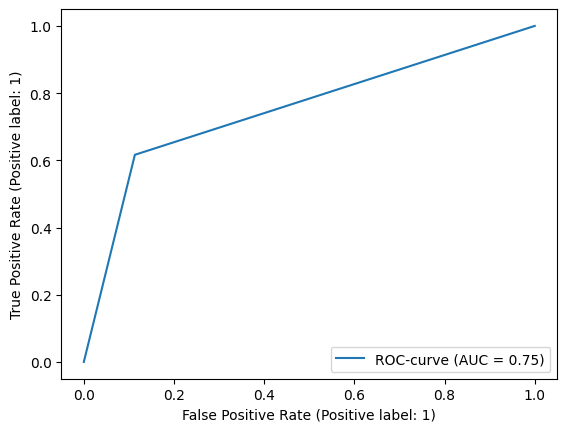

In [359]:
naive_bayes = Pipeline(steps = [('normalizer', Normalizer()),('bn', GaussianNB())])
naive_bayes.fit(x_train, y_train)

get_scores(naive_bayes, x_test, y_test)
pickle.dump(gscv.best_estimator_, open('models/sklearn_naive_bayes.pkl', 'wb'))